# Exploration 11. 폐렴을 진단해보자

### 1. Set-up

In [1]:
# 패키지들을 import 해보겠습니다.
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# 필요한 변수 생성
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'   # *은 모든 디렉토리와 파일을 의미한다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요.
BATCH_SIZE = 8
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


### 2. 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


> val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와 보겠다<br>
train과 val에 있는 데이터를 모은 다음에 train:val를 80:20으로 분할하겠다.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담는다.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눈다.
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


- train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한 번 보겠습니다.<br>
- 정상 이미지와 폐렴 이미지를 구분해야 하는데 다행히도 파일 경로에 힌트가 있다.

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pnuemonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0618-0001.jpeg
Pnuemonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person399_virus_793.jpeg


- 파일경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있다.<br>
- 또한, 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있다.

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set : {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in trainins set : {COUNT_PNEUMONIA}")

Normal images count in training set : 1070
Pneumonia images count in trainins set : 3115


- tf.data 인스턴스를 만들어 봅시다.<br>
- tf.data.는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해줍니다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

- train 데이터 셋, validation 데이터셋 개수 확인을 해봅시다.

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count : {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count : 4185
Validating images count: 1047


- 현재 이미지에는 라벨 데이터가 따로 없다.<br>
- 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 봅시다.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있다.
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"      # 폐렴이면 양성(True), 노말이면 음성(False)

- 이미지의 사이즈를 통일 시키고 GPU메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅니다.<br>
- decode_img 함수와 process_path 함수를 만들겠습니다.<br>
- 위의 두 함수를 이용해서 이미지의 데이터 타입을 float로 바꾸고 사이즈를 변경한다.<br>
- get_label을 이용해서 라벨 값을 가져온다.

In [10]:
# 이미지를 알맞은 형식으로 바꾼다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)  # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32)    # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE)  # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어온다.
def process_path(file_path):
    label = get_label(file_path)  # 라벨 검출
    img = tf.io.read_file(file_path)  # 이미지 읽기
    img = decode_img(img)   # 이미지를 알맞은 형식으로 수정
    return img, label

- train 데이터 셋과 validation 데이터 셋을 만듭니다.<br>
- num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 줄 수 있습니다.

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

- 이미지가 잘 resize 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해 봅시다.

In [12]:
for image, label in train_ds.take(1):            # train_ds.take(1)은 하나의 데이터만 가져온다는 의미이다.
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


- test 데이터 셋도 만들어 보겠습니다. 그리고 데이터 개수도 확인해 보겠습니다.

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     ds = ds.shuffle(buffer_size = shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)
#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

In [15]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 3. 데이터 시각화

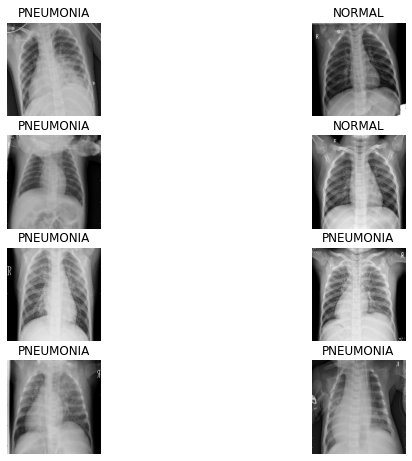

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 폐렴을 진단해보자(2)
### 4. CNN 모델링

- 먼저, Convolution block을 만듭니다.

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

- Dense Block은 아래와 같이 만듭니다.

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [19]:
# batch normalization과 dropout 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 살펴봅시다.
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 5. 데이터 imbalance 처리

In [20]:
weight_for_0 = (1/COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0    # 'NORMAL'이미지에 사용할 weight
weight_for_1 = (1/COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0  # 'Pneumonia' 이미지에 사용할 weight

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 6. 모델 훈련

In [21]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name ='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics = METRICS)

In [22]:
# 모델을 fit해보겠습니다.
with tf.device('/GPU:0'):
    history = model.fit(
    train_ds,
    steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs= EPOCHS,
    validation_data = val_ds,
    validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
    class_weight = class_weight,)

Epoch 1/25
523/523 [==============================] - 93s 120ms/step - loss: 0.5721 - accuracy: 0.6908 - precision: 0.8930 - recall: 0.6654 - val_loss: 1.1517 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
523/523 [==============================] - 61s 117ms/step - loss: 0.3107 - accuracy: 0.8617 - precision: 0.9628 - recall: 0.8478 - val_loss: 0.1988 - val_accuracy: 0.9106 - val_precision: 0.8932 - val_recall: 0.9974
Epoch 3/25
523/523 [==============================] - 60s 115ms/step - loss: 0.2516 - accuracy: 0.8989 - precision: 0.9710 - recall: 0.8912 - val_loss: 0.2383 - val_accuracy: 0.9240 - val_precision: 0.9737 - val_recall: 0.9215
Epoch 4/25
523/523 [==============================] - 61s 117ms/step - loss: 0.2756 - accuracy: 0.8882 - precision: 0.9645 - recall: 0.8818 - val_loss: 0.2565 - val_accuracy: 0.8923 - val_precision: 0.9954 - val_recall: 0.8570
Epoch 5/25
523/523 [==============================] - 59s 112ms/step - loss: 0.2558 - accura

### 7. 결과 확인

- 그래프로 Epochs마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

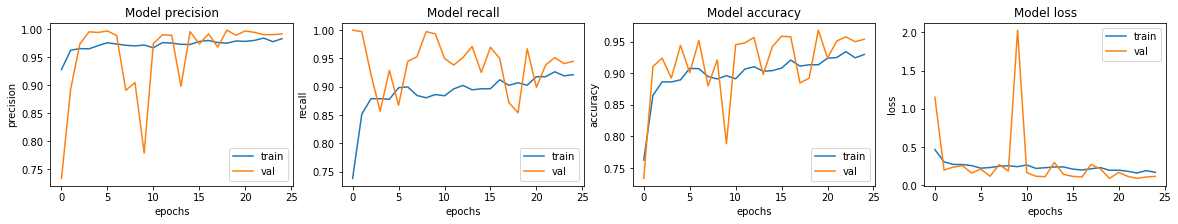

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
# 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해보겠습니다.
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss}, \nAccuracy: {accuracy}, \nPrecison: {precision}, \nRecall: {recall}')

78/78 [==============================] - 6s 75ms/step - loss: 0.3837 - accuracy: 0.8670 - precision: 0.8465 - recall: 0.9615
Loss: 0.38369065523147583, 
Accuracy: 0.8669871687889099, 
Precison: 0.8465011119842529, 
Recall: 0.9615384340286255


# 회고

### 성능 개선을 위한 시도
-------------------------------------------------------------
- 1번째 : BATCH_SIZE = 16 <br>
    - Loss: 0.7161460518836975, <br>
      Accuracy: 0.8349359035491943, <br>
      Precison: 0.7946611642837524, <br>
      Recall: 0.9923076629638672 <br>
- 2번째 : BATCH_SIZE = 32
    - Loss: 1.4252711534500122, <br>
      Accuracy: 0.7291666865348816, <br>
      Precison: 0.6976743936538696, <br>
      Recall: 1.0 <br>
- 3번째 : BATCH_SIZE = 8
    - Loss: 0.38369065523147583, <br>
      Accuracy: 0.8669871687889099, <br>
      Precison: 0.8465011119842529, <br>
      Recall: 0.9615384340286255 <br>
------------------------------------------------------------

- Augmentation기법을 사용하여 BATCH_SIZE를 노드에 적힌 16을 기준으로 결과를 보고 2번째 시도에서 32로 설정을 하고 돌려보았지만 오히려 Accuracy가 떨어지는 결과가 나왔다. 그래서 3번째 시도에서는 BATCH_SIZE를 8로 설정하고 돌려보았더니 Accuracy가 0.86698이 나왔다. <br>
<br>
- 3번째 시도만에 Accuracy 기준 85%를 넘었지만 BATCH-SIZE뿐만 아니라 여러가지 하이퍼파라미터들(epoch, dropout 등)을 수정하여 돌려보면 더 높은 정확도가 나올 것이라는 생각이 들었다. 모델을 학습하는데 있어서 다양한 하이퍼파라미터들을 수정하고 돌려보는 습관을 가지면 좋을 것 같다는 생각을 했다. <br>